In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torch_pconv import PConv2d  # Partial convolution layer; ensure this is installed.

In [2]:
class DepthInpaintingDatasetCSV(Dataset):
    def __init__(self, csv_file, target_size=(240,320), input_depth_size=(120,160),
                 mask_size=None, transform=None, apply_mask=True):
        """
        Args:
            csv_file: Path to a CSV file with two columns:
                      Column 0: RGB image paths.
                      Column 1: Depth image paths.
            target_size: The resolution for the target depth image (H, W) e.g. (240,320).
            input_depth_size: The resolution for the masked depth input (H, W) e.g. (120,160).
            mask_size: Not used for random mask generation.
            transform: Optional transforms applied after resizing/normalizing.
            apply_mask: Whether to apply a random mask.
        """
        self.data = pd.read_csv(csv_file, header=None)
        self.color_paths = self.data.iloc[:, 0].tolist()
        self.depth_paths = self.data.iloc[:, 1].tolist()
        self.target_size = target_size        # For depth target (and mask): e.g. (240,320)
        self.input_depth_size = input_depth_size  # For input masked depth: e.g. (120,160)
        self.transform = transform
        self.apply_mask = apply_mask

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Process the RGB image.
        rgb_path = self.color_paths[idx]
        rgb_path = os.path.join("..\\nyu_data\\", rgb_path)  # adjust path if needed
        rgb = cv2.imread(rgb_path)
        if rgb is None:
            raise ValueError(f"RGB image not found: {rgb_path}")
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb, (self.target_size[1], self.target_size[0]))
        rgb = cv2.normalize(rgb.astype(np.float32), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        rgb = np.clip(rgb, 0, 1)

        # print("RGB:", min(rgb.flatten()), max(rgb.flatten()))  # Debugging line to check RGB values

        # Process the depth image.
        depth_path = self.depth_paths[idx]
        depth_path = os.path.join("..\\nyu_data\\", depth_path)
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        if depth is None:
            raise ValueError(f"Depth image not found: {depth_path}")
        # Resize depth to target_size (240,320)
        depth = cv2.resize(depth, (self.target_size[1], self.target_size[0]))
        depth = cv2.normalize(depth.astype(np.float32), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        depth = np.clip(depth, 0, 1)

        # print("DEPTH:", min(depth.flatten()), max(depth.flatten()))  # Debugging line to check RGB values

        H, W = self.target_size  # e.g., (240,320)
        
        # Create a random mask at target resolution.
        if self.apply_mask:
            mask = self.create_random_mask((H, W))
            masked_depth_full = depth.copy()
            # Set masked pixels to white (1.0)
            masked_depth_full[mask == 0] = 1.0
        else:
            mask = np.ones((H, W), dtype=np.uint8) * 255
            masked_depth_full = depth

        # Downsample the masked depth (from target resolution to input_depth_size, e.g., 120x160)
        masked_depth_input = cv2.resize(masked_depth_full, (self.input_depth_size[1], self.input_depth_size[0]),
                                         interpolation=cv2.INTER_LINEAR)

        # Convert images to torch tensors.
        rgb_tensor = torch.from_numpy(rgb).permute(2, 0, 1)                # (3, H, W)
        depth_tensor = torch.from_numpy(depth).unsqueeze(0)                  # (1, H, W)
        masked_depth_tensor = torch.from_numpy(masked_depth_input).unsqueeze(0)  # (1, input_H, input_W)
        mask_tensor = torch.from_numpy(mask.astype(np.float32)/255.0).unsqueeze(0)  # (1, H, W)

        if self.transform:
            rgb_tensor = self.transform(rgb_tensor)
            depth_tensor = self.transform(depth_tensor)
            masked_depth_tensor = self.transform(masked_depth_tensor)
            mask_tensor = self.transform(mask_tensor)
        
        return {
            "rgb_input": rgb_tensor,          # (3, 240, 320)
            "depth_input": masked_depth_tensor,  # (1, 120, 160)
            "target": depth_tensor,           # (1, 240, 320)
            "mask": mask_tensor               # (1, 240, 320)
        }
    
    def create_random_mask(self, size):
        """
        Create a random mask of shape (H, W) using random lines.
        In the resulting mask, pixels with value 255 are unmasked, and pixels with value 0 are masked.
        """
        H, W = size
        mask = np.ones((H, W), dtype=np.uint8) * 255
        num_lines = np.random.randint(5, 10)  # Adjust the number of random lines if desired.
        for _ in range(num_lines):
            x1, x2 = np.random.randint(0, W, size=2)
            y1, y2 = np.random.randint(0, H, size=2)
            thickness = np.random.randint(1, 4)
            cv2.line(mask, (x1, y1), (x2, y2), 0, thickness)
        return mask

In [3]:
# ----------------------- Helper Functions -----------------------
def conv7x7(in_channels, out_channels, stride=1, negative_slope=0.2):
    """
    A 7x7 convolution block with BatchNorm and LeakyReLU.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=stride, padding=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=negative_slope, inplace=True)
    )

def conv5x5(in_channels, out_channels, negative_slope=0.2):
    """
    A 5x5 convolution block with BatchNorm and LeakyReLU.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=negative_slope, inplace=True)
    )

# ----------------------- Depth Inpainting CNN with attention -----------------------
class DepthAttention(nn.Module):
    def __init__(self, in_channels):
        """
        Args:
          in_channels: the number of channels in the rgb features (e.g. 16)
        """
        super(DepthAttention, self).__init__()
        # This convolution maps the 1-channel masked depth to an attention map with the same number of channels.
        self.conv = nn.Conv2d(1, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn   = nn.BatchNorm2d(in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, rgb_features, masked_depth):
        # Produce an attention map (B, in_channels, H, W).
        attn_map = self.conv(masked_depth)
        attn_map = self.bn(attn_map)
        attn_map = self.sigmoid(attn_map)
        # Multiply the rgb features (B, in_channels, H, W) by the attention map.
        attended_features = rgb_features * attn_map
        # Residual fusion: add the original features back.
        fused_features = rgb_features + attended_features
        return fused_features

# ----------------------- Depth Inpainting CNN -----------------------
class DepthInpaintCNN_Attention(nn.Module):
    def __init__(self, negative_slope=0.2):
        super(DepthInpaintCNN_Attention, self).__init__()
        # Hidden Layer 1: Process RGB input.
        # (B,3,240,320) --> conv7x7(stride=2) --> (B,16,120,160)
        self.conv1 = conv7x7(in_channels=3, out_channels=16, stride=2, negative_slope=negative_slope)
        
        # Attention Module: Fuse features from RGB (16 channels) with masked depth.
        self.depth_attention = DepthAttention(in_channels=16)
        
        # Hidden Layer 2: Process fused features.
        # Now input channels are 16, so we update accordingly.
        self.conv2 = conv7x7(in_channels=16, out_channels=32, stride=1, negative_slope=negative_slope)
        
        # Hidden Layer 3: 7x7 conv, stride=1 → (B,32,120,160) mapped to 64 channels.
        self.conv3 = conv7x7(in_channels=32, out_channels=64, stride=1, negative_slope=negative_slope)
        
        # Hidden Layer 4: 5x5 conv, stride=1 → (B,64,120,160)
        self.conv4 = conv5x5(in_channels=64, out_channels=64, negative_slope=negative_slope)
        
        # Hidden Layer 5: 5x5 conv, stride=1 → (B,64,120,160)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn5   = nn.BatchNorm2d(64)
        self.leaky5 = nn.LeakyReLU(negative_slope=negative_slope, inplace=True)
        # Shortcut connection comes from conv3's output (B,64,120,160).
        
        # Output Layer: Deconvolution.
        # Upsample from (120,160) to (240,320) with stride=2 using kernel_size=7, padding=3, output_padding=1.
        self.output_deconv = nn.ConvTranspose2d(
            in_channels=64, out_channels=1,
            kernel_size=7, stride=2,
            padding=3, output_padding=1,
            bias=False
        )
    
    def forward(self, rgb, masked_depth):
        """
        Args:
          rgb: Tensor of shape (B, 3, 240, 320)
          masked_depth: Tensor of shape (B, 1, 120, 160)
        Returns:
          inpainted depth: Tensor of shape (B, 1, 240, 320)
        """
        # Hidden Layer 1: Process the RGB image.
        feat1 = self.conv1(rgb)  # (B,16,120,160)
        
        # Fuse using attention: use masked depth to modulate rgb features.
        fused_feat = self.depth_attention(feat1, masked_depth)  # still (B,16,120,160)
        
        # Hidden Layer 2.
        feat2 = self.conv2(fused_feat)  # (B,32,120,160)
        
        # Hidden Layer 3.
        feat3 = self.conv3(feat2)  # (B,64,120,160)
        
        # Hidden Layer 4.
        feat4 = self.conv4(feat3)  # (B,64,120,160)
        
        # Hidden Layer 5 with shortcut from feat3.
        feat5_conv = self.conv5(feat4)         # (B,64,120,160)
        feat5_bn   = self.bn5(feat5_conv)
        feat5 = self.leaky5(feat5_bn + feat3)    # (B,64,120,160)
        
        # Output Layer: Upsample to full resolution.
        out_depth = self.output_deconv(feat5)  # (B,1,240,320)
        return out_depth

In [4]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader):
        depth_input = batch["depth_input"].to(device)
        rbg_input = batch["rgb_input"].to(device) 
        target = batch["target"].to(device)
        
        optimizer.zero_grad()
        output = model(rbg_input, depth_input)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * depth_input.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            depth_input = batch["depth_input"].to(device)
            rgb_input = batch["rgb_input"].to(device)
            target = batch["target"].to(device)

            output = model(rgb_input, depth_input)
            loss = criterion(output, target)
            
            running_loss += loss.item() * depth_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [5]:
train_csv = r"C:\Users\user\Desktop\CSCE748_Computational-Photography\nyu_data\data\nyu2_train.csv"
test_csv  = r"C:\Users\user\Desktop\CSCE748_Computational-Photography\nyu_data\data\nyu2_test.csv"

full_train_dataset = DepthInpaintingDatasetCSV(train_csv, target_size=(240,320), mask_size=(32, 32), apply_mask=True)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])  
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataset = DepthInpaintingDatasetCSV(test_csv, target_size=(240,320), mask_size=(32, 32), apply_mask=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 40550
Val samples: 10138
Test samples: 654


In [6]:
def show_sample(sample_dict, idx=0):
    # Convert tensors to NumPy arrays.
    rgb_input_np = sample_dict["rgb_input"][idx].permute(1, 2, 0).cpu().numpy()
    depth_input_np = sample_dict["depth_input"][idx].permute(1, 2, 0).cpu().numpy()
    target_np = sample_dict["target"][idx].permute(1, 2, 0).cpu().numpy()

    # For depth images, squeeze the last dimension if present.
    if depth_input_np.shape[2] == 1:
        depth_input_np = depth_input_np[..., 0]
    if target_np.shape[2] == 1:
        target_np = target_np[..., 0]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(rgb_input_np)
    axs[0].set_title("RGB Image")
    axs[0].axis("off")

    im1 = axs[1].imshow(depth_input_np, cmap="viridis", vmin=0, vmax=1)
    axs[1].set_title("Depth Image")
    axs[1].axis("off")
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(target_np, cmap="viridis", vmin=0, vmax=1)
    axs[2].set_title("Target")
    axs[2].axis("off")
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


torch.Size([16, 3, 240, 320])
torch.Size([16, 1, 120, 160])
torch.Size([16, 1, 240, 320])


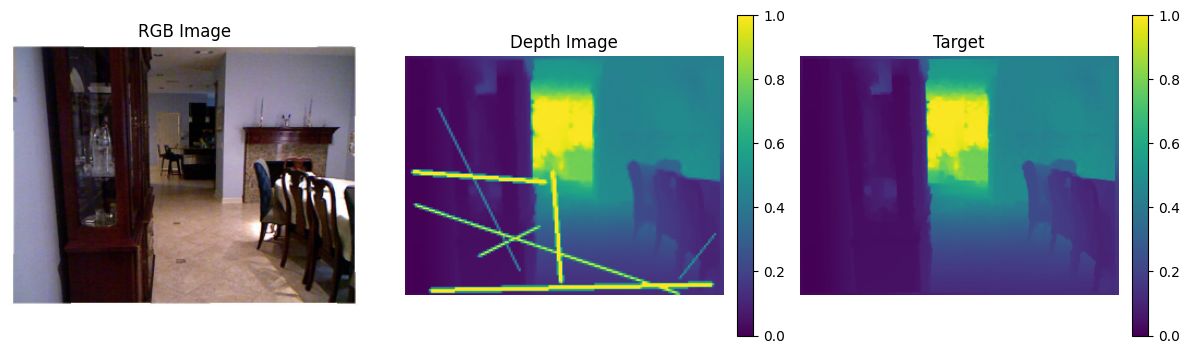

In [7]:
sample_batch = next(iter(train_loader))

print(sample_batch["rgb_input"].shape)
print(sample_batch["depth_input"].shape)            
print(sample_batch["target"].shape)              

# Visualize first sample in the batch
show_sample(sample_batch, idx=0)

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = DepthInpaintCNN_Attention().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

cuda


c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(1, num_epochs+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "nyu_inpainting_attention.pth")
        print(f"Saved best model with Val Loss: {best_val_loss:.4f}")

In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = DepthInpaintCNN_Attention().to(device)
model.load_state_dict(torch.load("nyu_inpainting_attention.pth", map_location=device))
model.eval()

cuda


DepthInpaintCNN_Attention(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (depth_attention): DepthAttention(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sigmoid): Sigmoid()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU

Sample 0:
SSD between Inpainted vs GT: 28.355595
SSD between Masked vs GT: 1451.3273
Sample 1:
SSD between Inpainted vs GT: 37.184036
SSD between Masked vs GT: 1330.6305
Sample 2:
SSD between Inpainted vs GT: 43.994884
SSD between Masked vs GT: 256.89795


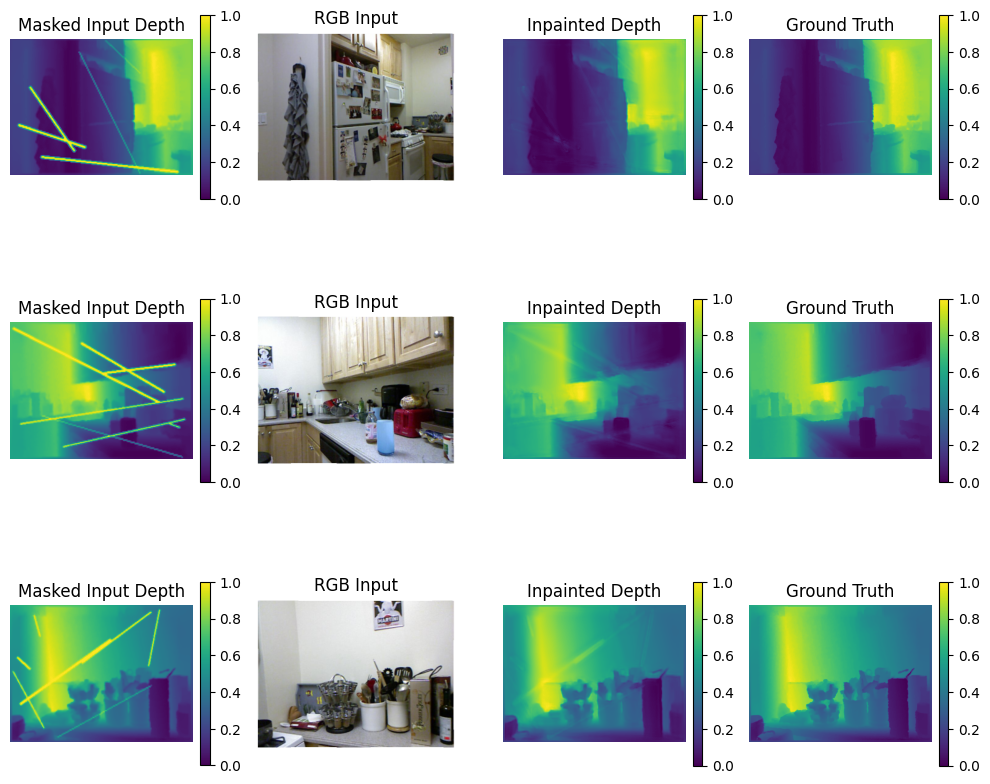

In [11]:
# Select a few samples from the test dataset.
sample_idx = 50
rows = 3
samples = [test_dataset[i] for i in range(sample_idx, sample_idx + rows)]
input_images  = torch.stack([s["rgb_input"] for s in samples], dim=0)       # (B, 3, H, W)
input_depths  = torch.stack([s["depth_input"] for s in samples], dim=0)     # (B, 1, h, w) where h=120, w=160
sample_labels = torch.stack([s["target"] for s in samples], dim=0)          # (B, 1, H, W)

inpainted_images = []
with torch.no_grad():
    for i in range(rows):
        input_rgb = input_images[i].unsqueeze(0).to(device)
        input_depth = input_depths[i].unsqueeze(0).to(device)
        pred = model(input_rgb, input_depth)  # Model takes both RGB and masked depth.
        inpainted_images.append(pred.squeeze(0).cpu())

# Create the figure and subplots.
fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(10, 3*rows))

for i in range(rows):
    # Get tensors and convert them to NumPy arrays.
    # For depth images, squeeze the channel.
    # Note: The "rgb_input" might be used for reference, but here we focus on depth images.
    rgb_np = input_images[i].permute(1, 2, 0).cpu().numpy()  # shape (H,W,3)
    # For depth, we assume they are single channel.
    # Here, we resize the masked depth to the target size (if needed) for display.
    depth_np = input_depths[i].squeeze(0).cpu().numpy()        # shape (h, w) = (120,160)
    # If you want to show the depth images at (240,320), you can upsample; otherwise, display as is.
    # Here we'll show the model outputs and ground truth which are at full resolution.
    inpainted_np  = inpainted_images[i].squeeze(0).cpu().numpy()  # shape: (H,W)
    gt_depth      = sample_labels[i].squeeze(0).cpu().numpy()      # shape: (H,W)

    # (Optional) If you wish to upsample the masked input depth to target resolution for display:
    depth_np_up = cv2.resize(depth_np, (gt_depth.shape[1], gt_depth.shape[0]),
                             interpolation=cv2.INTER_LINEAR)
    
    print(f"Sample {i}:")
    print("SSD between Inpainted vs GT:", np.sum((inpainted_np - gt_depth)**2))
    print("SSD between Masked vs GT:", np.sum((depth_np_up - gt_depth)**2))
    
    # Plot the masked depth input (upsampled), inpainted depth, and ground truth.
    # For each, we'll add a colorbar.
    
    im0 = axs[i, 0].imshow(depth_np_up, cmap="viridis", vmin=0, vmax=1)
    axs[i, 0].set_title("Masked Input Depth")
    axs[i, 0].axis("off")
    fig.colorbar(im0, ax=axs[i, 0], fraction=0.046, pad=0.04)
    
    # Show the RGB input for reference.
    im1 = axs[i, 1].imshow(rgb_np)
    axs[i, 1].set_title("RGB Input")
    axs[i, 1].axis("off")
    # (Colorbar for RGB image is typically not needed.)
    
    im2 = axs[i, 2].imshow(inpainted_np, cmap="viridis", vmin=0, vmax=1)
    axs[i, 2].set_title("Inpainted Depth")
    axs[i, 2].axis("off")
    fig.colorbar(im2, ax=axs[i, 2], fraction=0.046, pad=0.04)
    
    im3 = axs[i, 3].imshow(gt_depth, cmap="viridis", vmin=0, vmax=1)
    axs[i, 3].set_title("Ground Truth")
    axs[i, 3].axis("off")
    fig.colorbar(im3, ax=axs[i, 3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [14]:
ssd_inpainted_total = 0.0
ssd_masked_total = 0.0
num_images = 0

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        rgb_input = batch["rgb_input"].to(device)
        depth_input = batch["depth_input"].to(device)
        gt = batch["target"].to(device)
        
        pred = model(rgb_input, depth_input) 
        
        # Upsample the depth input to match gt resolution (assuming gt is shape (B,1,H,W))
        depth_input_up = F.interpolate(depth_input, size=gt.shape[2:], mode='bilinear', align_corners=False)
        
        pred_np = pred.cpu().numpy()
        gt_np   = gt.cpu().numpy()
        depth_np_up = depth_input_up.cpu().numpy()

        batch_size = pred_np.shape[0]
        for i in range(batch_size):
            # If you really want Sum of Squared Differences (SSD), square the differences.
            ssd_inpainted = np.sum((pred_np[i] - gt_np[i]) ** 2)
            ssd_masked    = np.sum((depth_np_up[i] - gt_np[i]) ** 2)
            ssd_inpainted_total += ssd_inpainted
            ssd_masked_total += ssd_masked
        
        num_images += batch_size

avg_ssd_inpainted = ssd_inpainted_total / num_images
avg_ssd_masked = ssd_masked_total / num_images

print("Average SSD (Inpainted vs GT):", avg_ssd_inpainted)
print("Average SSD (Masked vs GT):", avg_ssd_masked)
print("Ratio: ", avg_ssd_inpainted / avg_ssd_masked)

100%|██████████| 41/41 [00:07<00:00,  5.18it/s]

Average SSD (Inpainted vs GT): 40.59707180658976
Average SSD (Masked vs GT): 757.5125032127451
Ratio:  0.0535926095403183
